### Burgers Equation 
General form:
$$\frac{\partial u(t,x)}{\partial t} + \lambda _{1} u(t,x) \frac{\partial u(t,x)}{\partial x} -\lambda _{2} \frac{\partial^2 u(t,x)}{\partial x^2} = 0$$
We will work on the following form: $$\frac{\partial u(t,x)}{\partial t} + u(t,x) \frac{\partial u(t,x)}{\partial x} -\frac{0.01}{\pi} \frac{\partial^2 u(t,x)}{\partial x^2} = 0$$
With the following boundary and initial conditions:
$$u(0,x) = -sin(\pi x) \textrm{, which is the initial condition}$$ <br>
$$u(t,-1) = u(t,1) = 0 \textrm{, which is the Dirichlet boundary conditions}$$<br>
$$x \in [-1,1], \textrm{ }t\in [0,1]$$

### Data Generation

In [31]:
import scipy.io
from pyDOE import lhs
import numpy as np

np.random.seed(1234)

lambda_1 = 1
lambda_2 = 0.01/np.pi     

N_u = 100
N_f = 10000

data = scipy.io.loadmat('burgers_shock.mat')
x_sol = data['x'].flatten()[:,None] #256,1
t_sol = data['t'].flatten()[:,None] #100,1
U_sol = np.real(data['usol']) #256,100

X, T = np.meshgrid(x_sol, t_sol) #X 256,100; T 256,100

x_t_sol = np.hstack(( X.flatten()[:,None], T.flatten()[:,None])) #25600, 2, exact solution input pairs (t,x)
u_sol = U_sol.flatten()[:,None] #25600, 1, exact solution u(t,x)  

ic = np.hstack((X[0:1,:].T, T[0:1,:].T)) #256, 2; corresponds to the initial condition points u(t=0,x) = -sin(pix)
#ic_sol = Exact[:,0:1]
ic_sol = -np.sin(ic[:,0:1]*np.pi)

bc1 = np.hstack((X[:,0:1], X[:,0:1])) #100, 2; correspond to the first boundary condition u(t,x=-1) = 0
#bc1_sol = Exact[0:1,:].T #100, 1; exact solution for the first boundary condition
bc1_sol = np.zeros(bc1[:,0:1].shape)

bc2 = np.hstack((X[:,-1:], T[:,-1:])) #100, 2; corresponds to the second boundary condition u(t,x=1) = 0
#bc2_sol = Exact[-1:,:].T #100, 1; exact solution for the second boundary condition
bc2_sol = np.zeros(bc2[:,-1:].shape)

x_t_train = np.vstack([ic, bc1, bc2]) #456, 2 #points of initial and boundaries conditions points
x_t_train_reserve = x_t_train.copy()
u_train = np.vstack([ic_sol, bc1_sol, bc2_sol]) # 456, 1; stack the exact solution points for initial and boundaries conditions
u_train_reserve = u_train.copy()

lower_bound_domain = x_t_sol.min(0)
upper_bound_domain = x_t_sol.max(0)

def generate_training_data(Nu, Nf, xt_tr, u_tr, lb, ub):
    #Latin hypercube sampling: creates 10000 near random pairs of (x,t) in the domain [-1,1]x[0,0.99], used for PDE
    xt_f = lb + (ub-lb)*lhs(2, Nf) #10000, 2 
    #stack initial and boundaries points with PDE points, so all the the initial and boundaries points can also be used for the PDE 
    xt_f = np.vstack((xt_f, xt_tr)) #10456, 2 
    
    #(100,) 100 permutations from the 456 initial and boundaries conditions, N_u = 100
    idx = np.random.choice(xt_tr.shape[0], Nu, replace=False) 
    xt_tr = xt_tr[idx, :] #100,2 randomly points from the 456 initial and boundaries conditions
    u_tr = u_tr[idx,:] #100,1 randomly points from the 456 exact solutions points of initial and boundaries conditions
    
    return xt_f, xt_tr, u_tr

x_t_f, x_t_train, u_train = generate_training_data(N_u, N_f, x_t_train, u_train, lower_bound_domain, upper_bound_domain)

print(f"Training data size: {x_t_train.shape}")
print(f"Collocation points size: {x_t_f.shape}")

Training data size: (100, 2)
Collocation points size: (10456, 2)


### DNN definition

In [32]:
import torch
torch.manual_seed(0)
from collections import OrderedDict 
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(len(layers) - 2): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (len(layers) - 2), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)

        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out

### PINN definition

In [33]:
import torch.optim as optim

class PINN():
    def __init__(self, layers, xt_tr, u_tr, xt_f, lambda_1, lambda_2, max_iter=1, learning_rate=1.0, hs=50, tol = 1e-5, verbose=True):
        
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        print(f"device used: {self.device}")
        
        
        self.x_tr = torch.tensor(xt_tr[:, 0:1], requires_grad=True).float().to(self.device) 
        self.t_tr = torch.tensor(xt_tr[:, 1:2], requires_grad=True).float().to(self.device) 
        self.x_f = torch.tensor(xt_f[:, 0:1], requires_grad=True).float().to(self.device)
        self.t_f = torch.tensor(xt_f[:, 1:2], requires_grad=True).float().to(self.device) 
        self.u_tr = torch.tensor(u_tr).float().to(self.device)
        self.zeros = torch.torch.zeros(self.x_f.shape).float().to(self.device)
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2
        self.verbose = verbose
 
        self.net = DNN(layers).to(self.device)
    
        self.iter = 1
       
        self.max_iter = max_iter
        
        #self.criterion = torch.nn.MSELoss()
        
        self.optimizer = torch.optim.LBFGS(
            self.net.parameters(), 
            lr=learning_rate, 
            max_iter=50000, 
            max_eval=50000, 
            history_size= hs,
            tolerance_grad=tol, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"    
        )
            
    def net_u(self, x, t): #get u(t,x) for a pair (x,t); a forward pass through the PINN
        u = self.net(torch.cat([x, t], dim=1))
        return u #u(t,x)
    
    def net_f(self, x, t, get_all = False): #get f = u_t + u * u_x - self.nu * u_xx; the true u(x,t) makes f = 0
        u = self.net_u(x, t)
        u_t = torch.autograd.grad( #first partial derivative with respect to t
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x = torch.autograd.grad( #first partial derivative with respect to x
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_xx = torch.autograd.grad( #second partial derivative with respect to x
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]
        f = u_t + self.lambda_1 * u * u_x - self.lambda_2 * u_xx #the computed PDE, we want to be a close as possible to 0
        if get_all:
            return f, u, u_t, u_x, u_xx
        else:
            return f
        
    def pinn_loss(self):
        self.optimizer.zero_grad()
        
        u_pred = self.net_u(self.x_tr, self.t_tr) #100, 1; all the ic/bc pairs were feeded through the PINN
        #loss_u = self.criterion(u_pred, self.u_tr)
        loss_u = torch.mean((self.u_tr - u_pred) ** 2) #MSE loss on the ic/bc pairs, MSE loss on trainset, classic NN
        
        f_pred = self.net_f(self.x_f, self.t_f) #10456, 1; all the collocations points were feeded through the PINN
        #loss_f = self.criterion(f_pred, self.zeros)
        loss_f = torch.mean(f_pred ** 2) #MSE loss on the collocations pairs, regularization term
        
        loss = loss_u + loss_f #classic loss + regularization loss (enforce the PDE structure) => PINN loss
        
        loss.backward() #backpropagation
        
        self.iter += 1
        if self.verbose:
            if self.iter % 100 == 0:
                print(
                    'Iter %d, Loss: %.5e, Loss_u: %.5e, Loss_f: %.5e' % (self.iter, loss.item(), loss_u.item(), loss_f.item())
                )
        return loss
    
    def train(self):
        for i in range(self.max_iter):
            self.net.train()
            self.optimizer.step(self.pinn_loss)

            
    def predict(self, x_t):
        x = torch.tensor(x_t[:, 0:1], requires_grad=True).float().to(self.device) #get x from pair
        t = torch.tensor(x_t[:, 1:2], requires_grad=True).float().to(self.device) #get t from pair
        self.net.eval()
        f, u, ut, ux, uxx = self.net_f(x, t, True)
        u = self.net_u(x, t) 
        f = self.net_f(x, t) 
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return u, ut, ux, uxx, f

### Network Parameters

In [34]:
nodes_per_layer = 20
hidden_layers = 9
layers = np.hstack([np.array([2]),np.full(hidden_layers, nodes_per_layer),np.array([1])])

"""net = DNN(layers)
print(net)

params = list(net.parameters())
#print(len(params))
for par in params:
    print(par.shape)"""

max_iter = 1
lr = 1.0
history_size = 50
tol = 1e-5

### Create and train

In [35]:
model = PINN(layers, x_t_train, u_train, x_t_f, lambda_1, lambda_2, max_iter=max_iter, learning_rate=lr, hs=history_size, tol = tol)
model.train()

device used: cuda:0
Iter 100, Loss: 8.23585e-02, Loss_u: 5.60065e-02, Loss_f: 2.63519e-02
Iter 200, Loss: 4.94418e-02, Loss_u: 3.58419e-02, Loss_f: 1.35999e-02
Iter 300, Loss: 2.88070e-02, Loss_u: 1.98433e-02, Loss_f: 8.96378e-03
Iter 400, Loss: 2.10788e-02, Loss_u: 1.56952e-02, Loss_f: 5.38370e-03
Iter 500, Loss: 1.63895e-02, Loss_u: 1.35349e-02, Loss_f: 2.85457e-03
Iter 600, Loss: 1.32809e-02, Loss_u: 1.09347e-02, Loss_f: 2.34619e-03
Iter 700, Loss: 1.15030e-02, Loss_u: 9.77570e-03, Loss_f: 1.72731e-03
Iter 800, Loss: 9.64373e-03, Loss_u: 6.98946e-03, Loss_f: 2.65428e-03
Iter 900, Loss: 7.40653e-03, Loss_u: 4.25579e-03, Loss_f: 3.15073e-03
Iter 1000, Loss: 3.88903e-03, Loss_u: 1.24422e-03, Loss_f: 2.64481e-03
Iter 1100, Loss: 2.61989e-03, Loss_u: 8.38480e-04, Loss_f: 1.78141e-03
Iter 1200, Loss: 1.84328e-03, Loss_u: 4.72808e-04, Loss_f: 1.37047e-03
Iter 1300, Loss: 1.33600e-03, Loss_u: 4.14779e-04, Loss_f: 9.21216e-04
Iter 1400, Loss: 1.05503e-03, Loss_u: 3.27593e-04, Loss_f: 7.27442

### Evaluate

In [36]:
def L_2_norm (pred, true):
    return np.linalg.norm(pred-true,2)/np.linalg.norm(true,2)
def MSE (pred, true):
    return float(((pred - true)**2).mean(axis=0))

In [37]:
u_pred, _, _, _, f_pred = model.predict(x_t_sol)

L2_error_u = L_2_norm(u_pred, u_sol)

MSE_error_u = MSE(u_pred, u_sol)
MSE_error_f = MSE(f_pred, np.zeros(f_pred.shape))

print(f"L2 norm error u(t,x): {L2_error_u}")
print(f"MSE error u(t,x): {MSE_error_u}")
print(f"MSE error PDE: {MSE_error_f}")

from scipy.interpolate import griddata
U_pred = griddata(x_t_sol, u_pred.flatten(), (X, T), method='cubic')
#Error = np.abs(Exact - U_pred) #100, 256 matrix of errors compared to burgers_shock.mat

L2 norm error u(t,x): 1.4140179756130054
MSE error u(t,x): 0.7546123919166816
MSE error PDE: 2.8301647983311738e-05


### Plot

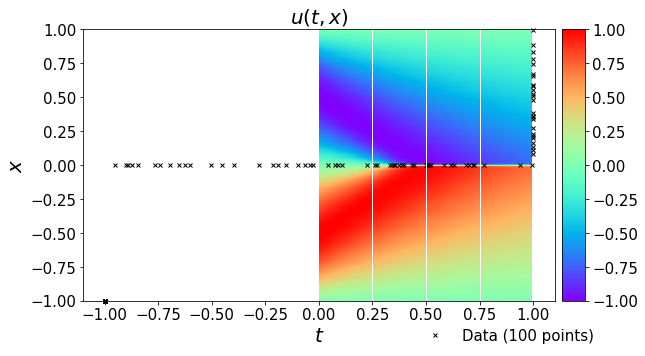

In [38]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t_sol.min(), t_sol.max(), x_sol.min(), x_sol.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 

ax.plot(
    x_t_train[:,0], 
    x_t_train[:,1], 
    'kx', label = 'Data (%d points)' % (u_train.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=1.0
)

line = np.linspace(x_sol.min(), x_sol.max(), 2)[:,None]
ax.plot(t_sol[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t_sol[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t_sol[75]*np.ones((2,1)), line, 'w-', linewidth = 1)

ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled
ax.tick_params(labelsize=15)

plt.show()

In [ ]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111)

gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1.0/3.0-0.1, bottom=1.0-2.0/3.0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x_sol,U_sol[:,25], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x_sol,U_pred[:,25], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = 0.25$', fontsize = 15)
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 1])
ax.plot(x_sol,U_sol[:,50], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x_sol,U_pred[:,50], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_title('$t = 0.50$', fontsize = 15)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.15), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 2])
ax.plot(x_sol,U_sol[:,75], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x_sol,U_pred[:,75], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])    
ax.set_title('$t = 0.75$', fontsize = 15)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

plt.show()

### Network architecture comparison

In [ ]:
nb_neurons = [10, 20, 40]
nb_hidden_layers = [2, 4, 6, 8, 10]

L2_u_1 = list
MSE_u_1 = list()
MSE_f_1 = list()

for i in range(nb_hidden_layers):
    for j in range(nb_neurones):
        layers = np.hstack([np.array([2]),np.full(nb_hidden_layers[i], nb_neurons[j]),np.array([1])])
        #verbose = False
        model = PINN(layers, x_t_train, u_train, x_t_f, lambda_1, lambda_2, max_iter=max_iter, learning_rate=lr, hs=history_size, tol = tol, verbose = False)
        model.train()
        u_pred, _, _, _, f_pred = model.predict(x_t_sol)
        L2_u_1.append(L_2_norm(u_pred, u_sol))
        MSE_u_1.append(MSE(u_pred, u_sol))
        MSE_f_1.append(MSE(f_pred, np.zeros(f_pred.shape)))
        

Nu = [10, 50 , 100, 200]
Nf = [1000, 2000, 5000, 1000]

L2_u_2 = list
MSE_u_2 = list()
MSE_f_2 = list()
nodes_per_layer = 20
hidden_layers = 9
layers = np.hstack([np.array([2]),np.full(hidden_layers, nodes_per_layer),np.array([1])])

for i in range(Nu):
    for j in range(Nf):
        x_t_f, x_t_train, u_train = generate_training_data(Nu[i], Nf[f], xt_train_reserve, u_train_reserve, lower_bound_domain, upper_bound_domain)
        #verbose = False
        model = PINN(layers, x_t_train, u_train, x_t_f, lambda_1, lambda_2, max_iter=max_iter, learning_rate=lr, hs=history_size, tol = tol, verbose = False)
        model.train()
        u_pred, _, _, _, f_pred = model.predict(x_t_sol)
        L2_u_2.append(L_2_norm(u_pred, u_sol))
        MSE_u_2.append(MSE(u_pred, u_sol))
        MSE_f_2.append(MSE(f_pred, np.zeros(f_pred.shape)))